In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [ ]:
df = pd.read_csv('bigframe.csv')

In [122]:
print(df.shape)
df.head()

(1425447, 28)


,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,brewery_id,brewery_type,brewery_country,...,venue_state,venue_cat,venue_id,checkin_comment,venue_type,rating_global,beer_description,abv,date,ipa
0,821797539,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,1204,Regional Brewery,United States,...,NaN,NaN,NaN,"Easy-drinking, not too hoppy. Solid.",[],3.73789,To create a recipe so tropical and fruity with...,7.5,2019-10-26 03:52:50+00:00,True
1,818949121,1709568,3340203,3.50,Ritual Brewing Company,Pale Ale,Pale Ale - American,39329,Micro Brewery,United States,...,CA,Nightlife Spot,376422.0,Solid.,['brewery'],3.43165,NaN,5.2,2019-10-19 03:07:43+00:00,False
2,818856642,2734572,3340203,4.25,Ritual Brewing Company,Oil Rig,IPA - Imperial / Double,39329,Micro Brewery,United States,...,CA,Nightlife Spot,376422.0,Gooood stuff. Cool place too.,['brewery'],3.87873,NEW TRADITIONS CALL FOR NEW HOLIDAYS AND NEW H...,9.0,2019-10-19 00:37:37+00:00,True
3,815159720,1044097,3340203,4.25,Stone Brewing,Stone Ruination Double IPA 2.0,IPA - Imperial / Double,1204,Regional Brewery,United States,...,NaN,NaN,NaN,Probably the best Stone beer I’ve had. I’m a fan.,[],4.01290,Stone Ruination IPA was the first full-time br...,8.5,2019-10-10 02:20:55+00:00,True
4,814916483,1070,3340203,3.75,Lagunitas Brewing Company,Imperial Stout,Stout - Russian Imperial,765,Macro Brewery,United States,...,NaN,NaN,NaN,"A really nice, if unspectacular, stout.",[],3.91420,"Made with Highly roasted malted barley, and pl...",9.9,2019-10-09 04:25:53+00:00,False


In [237]:
df.date[:5]

0    2019-10-26 03:52:50+00:00
1    2019-10-19 03:07:43+00:00
2    2019-10-19 00:37:37+00:00
3    2019-10-10 02:20:55+00:00
4    2019-10-09 04:25:53+00:00
Name: date, dtype: object

In [238]:
# pd.to_csv changes datetimes back to strings, so this has to be converted back to datetimes now

df['date'] = pd.to_datetime(df.date)
df.date[:5]

0   2019-10-26 03:52:50+00:00
1   2019-10-19 03:07:43+00:00
2   2019-10-19 00:37:37+00:00
3   2019-10-10 02:20:55+00:00
4   2019-10-09 04:25:53+00:00
Name: date, dtype: datetime64[ns, UTC]

=====================================================================================================================

Each line in these dataframes represents a single check-in by a user of the Untappd app, where the user left a rating for the beer.

The main focus of this project is predicting ratings specifically for IPA's, as opposed to the dozens of other styles of beer.  To that end, and despite the memory it will use, it will be worth splitting the dataframe into two subframes at the start of analysis.

IPA's vs non-IPA's

In [26]:
df['ipa'] = df.beer_style.str.startswith('IPA')
# don't necessarily need that boolean column to be part of the frame, but it may be useful later
ipas = df[df.ipa]
non_ipas = df[df.ipa == False]

## This first part of the notebook explores the basic counts and distributions of the beers, users, and checkins.  The second part will focus on the ratings.

In [222]:
print(f"Number of IPA's reviewed: {len(ipas)}")
print(f"Number of unique IPA's: {ipas.beer_id.nunique()}")
print()
print(f'Number of other beers: {len(non_ipas)}')
print(f'Number of unique other beers: {non_ipas.beer_id.nunique()}')

Number of IPA's reviewed: 688887
Number of unique IPA's: 84894

Number of other beers: 736560
Number of unique other beers: 179749


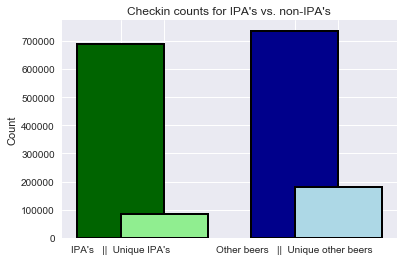

In [81]:
_ = plt.bar([1,2,5,6], [len(ipas), ipas.beer_id.nunique(),
                    len(non_ipas), non_ipas.beer_id.nunique()], 
        width=2, color=['darkgreen', 'lightgreen', 'darkblue', 'lightblue'],
        tick_label=["IPA's   ||  Unique IPA's", "", 'Other beers   ||  Unique other beers', ""],
        linewidth=2, edgecolor='k')

_ = plt.ylabel('Count')
_ = plt.title("Checkin counts for IPA's vs. non-IPA's")


#### The number of checkins is about the same for IPA's vs. non-IPA's, but the IPA checkins are much more concentrated on a smaller number of unique beers. 

Distribution of the number of ratings each user has in this dataset:

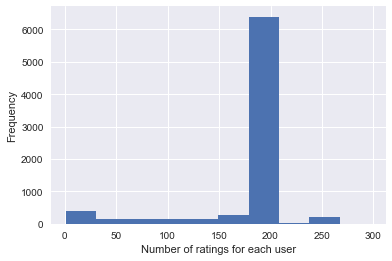

In [261]:
df.groupby('user_id').size().plot(kind='hist');
plt.xlabel('Number of ratings for each user');

Determining the best way to analyze and predict user ratings will in part depend on how sparse the ratings are.  I.e., how many users in this dataset rated each beer?

In [135]:
n_users = df.user_id.nunique()
n_beers = df.beer_id.nunique()
print(f'Number of reviewers in this set of 1.4 million reviews: {n_users}')
print(f'Number of beers reviewed in those 1.4 million reviews:  {n_beers}')
print(f'Beer-to-User ratio:  {np.round(n_beers / n_users, 3)}')
print(f'Avg. number of beers reviewed by each user: \
{np.round(df.groupby(df.user_id).size().mean(), 3)}')

Number of reviewers in this set of 1.4 million reviews: 7907
Number of beers reviewed in those 1.4 million reviews:  264620
Beer-to-User ratio:  33.467
Avg. number of beers reviewed by each user: 180.277


In [230]:
print(f'The ratio between the last 2 ratios shows that the average number of times any one \
beer was reviewed was {np.round(180.277 / 33.467, 3)}')

The ratio between the last 2 ratios shows that the average number of times any one beer was reviewed was 5.387


#### Another way of seeing that is to look at the previous bar chart, where we can see that for IPA's (the green bars), there are about 8 checkins for each unique beer, whereas for other styles (in blue) the ratio is about 4 checkins per unique beer.

So on the one hand, this describes an extremely sparse User x Beer matrix of ratings, but at least it is denser for the IPA ratings.
Let's see how that ratio is distributed.  Maybe the ratio holds somewhat even, and every beer has at least a few ratings.  Or maybe there's a small group of very popular/commonly available beers that get most of the ratings, and many more that are only rated once or twice.

In [174]:
counts = df.groupby(df.beer_id).size().sort_values(ascending=False)

print(f'The max number of reviews for any one beer is {counts.iloc[0]}')
print(f'The median number is {counts.iloc[len(counts) // 2]}')

The max number of reviews for any one beer is 2412
The median number is 2


#### This shows an extremely uneven, exponential distribution of ratings, with the max 1200 times higher than the median.  Attempts to use collaborative filtering to predict ratings are likely to rely very much on how users rated a small group of beers.

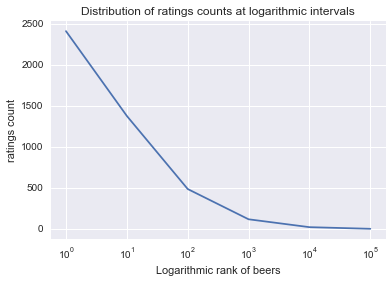

In [187]:
plt.plot([10**p for p in range(6)],[counts.iloc[10**p-1] for p in range(6)])
plt.xscale('log')
plt.title('Distribution of ratings counts at logarithmic intervals')
plt.xlabel('Logarithmic rank of beers')
plt.ylabel('ratings count');

In [259]:
for power in range(6):
    print(f'Beer {10**power}:')
    print(f'   {counts.iloc[10**power-1]} ratings')
print(f'Beers with just 1 rating:  {counts.value_counts().loc[1]}')

Beer 1:
   2412 ratings
Beer 10:
   1378 ratings
Beer 100:
   487 ratings
Beer 1000:
   118 ratings
Beer 10000:
   22 ratings
Beer 100000:
   2 ratings
Beers with just 1 rating:  123345


As far as where these beers are being rated and brewed:

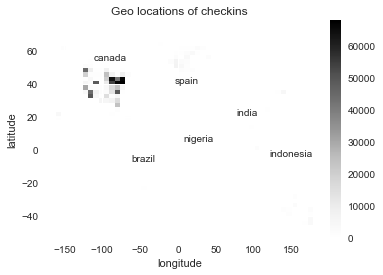

In [226]:
geos = df.dropna(subset=['venue_lat','venue_lon'])

_ = plt.hist2d(geos.venue_lon, geos.venue_lat, bins=50)
_ = plt.xlabel('longitude')
_ = plt.ylabel('latitude')
_ = plt.text(x=-5, y=40, s='spain')
_ = plt.text(x=-61, y=-7, s='brazil')
_ = plt.text(x=77, y=21, s='india')
_ = plt.text(x=7, y=5, s='nigeria')
_ = plt.text(x=-111, y=54, s='canada')
_ = plt.text(x=121, y=-4, s='indonesia')
_ = plt.title('Geo locations of checkins')
_ = plt.colorbar()

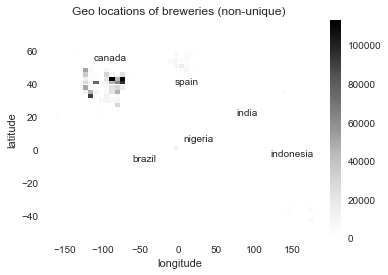

In [228]:
geos = df.dropna(subset=['brewery_lat','brewery_lon'])

_ = plt.hist2d(geos.brewery_lon, geos.brewery_lat, bins=50)
_ = plt.xlabel('longitude')
_ = plt.ylabel('latitude')
_ = plt.text(x=-5, y=40, s='spain')
_ = plt.text(x=-61, y=-7, s='brazil')
_ = plt.text(x=77, y=21, s='india')
_ = plt.text(x=7, y=5, s='nigeria')
_ = plt.text(x=-111, y=54, s='canada')
_ = plt.text(x=121, y=-4, s='indonesia')
_ = plt.title('Geo locations of breweries (non-unique)')
_ = plt.colorbar()

#### As expected, the bulk of the checkins are for breweries located in the NE of the U.S. and along its West Coast.  A secondary grouping of breweries lies in the U.K. and NW Europe, with a smaller cluster in SE Australia and New Zealand, plus one area in West Africa and another in Japan.  The checkin venues themselves (the upper of the two plots) are similarly distributed, although the people rating the West African beers are not doing so from that part of the world.

Perhaps the checkin (user) locations have been trending some direction over time?

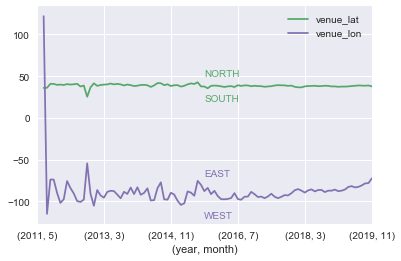

In [242]:
yrmo = df.groupby([df.date.dt.year, df.date.dt.month])

yrmo.venue_lat.mean().plot(color='C1')
yrmo.venue_lon.mean().plot(color='C3')
plt.legend()
plt.xlabel('(year, month)')
plt.text(s='NORTH', color='C1', x=50,y=50)
plt.text(s='SOUTH', color='C1', x=50,y=20)
plt.text(s='EAST', color='C3', x=50,y=-70)
plt.text(s='WEST', color='C3', x=50,y=-120);

#### The mean latitude of checkin venues has stayed very steady over the years, but the longitude has shifted significantly to the east in the last 2-3 years.

Having brought time into the equation, let's see if we can determine from this sample of 8K users how the flow of action for Untappd has evolved over time, i.e. how does growth look?  Since the checkins were pulled into this dataset by using Untappd's API, the data were retrieved in order of most recent checkins for each user.  That makes it impossible to use checkin counts to determine growth rate for the app.  But fortunately Untappd enumerates and indexes their checkins with the `checkin_id`, so we can use those as y-values and the checkin dates as x-values, to get a pretty accurate picture of Untappd's growth.

In [246]:
# set index to dates to be able to sort them and work with them faster
dated = df.set_index('date').sort_index()

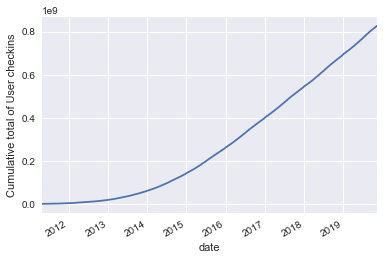

In [245]:
# This is a proxy for the flow of all checkins.  The rate of change of the slope is growth.
dated.checkin_id.plot()
plt.ylabel('Cumulative total of User checkins');

#### It looks like it was growing fastest 2013-2015 and has tapered off since then, but is slowly growing still.  Their billionth checkin should come in about a year.


Let's take a more detailed look at those same growth data.

In [247]:
# we'll take 13-week intervals and see the mean checkin_id for that quarter, then compare
## the quarter-on-quarter changes and see when they're growing fastest and slowest (a.k.a. growth)
dates = pd.date_range(start=dated.index[0], periods=35, freq='91D').normalize()  # remove the clock time
dates

DatetimeIndex(['2011-05-01 00:00:00+00:00', '2011-07-31 00:00:00+00:00',
               '2011-10-30 00:00:00+00:00', '2012-01-29 00:00:00+00:00',
               '2012-04-29 00:00:00+00:00', '2012-07-29 00:00:00+00:00',
               '2012-10-28 00:00:00+00:00', '2013-01-27 00:00:00+00:00',
               '2013-04-28 00:00:00+00:00', '2013-07-28 00:00:00+00:00',
               '2013-10-27 00:00:00+00:00', '2014-01-26 00:00:00+00:00',
               '2014-04-27 00:00:00+00:00', '2014-07-27 00:00:00+00:00',
               '2014-10-26 00:00:00+00:00', '2015-01-25 00:00:00+00:00',
               '2015-04-26 00:00:00+00:00', '2015-07-26 00:00:00+00:00',
               '2015-10-25 00:00:00+00:00', '2016-01-24 00:00:00+00:00',
               '2016-04-24 00:00:00+00:00', '2016-07-24 00:00:00+00:00',
               '2016-10-23 00:00:00+00:00', '2017-01-22 00:00:00+00:00',
               '2017-04-23 00:00:00+00:00', '2017-07-23 00:00:00+00:00',
               '2017-10-22 00:00:00+00:00', '2018-0

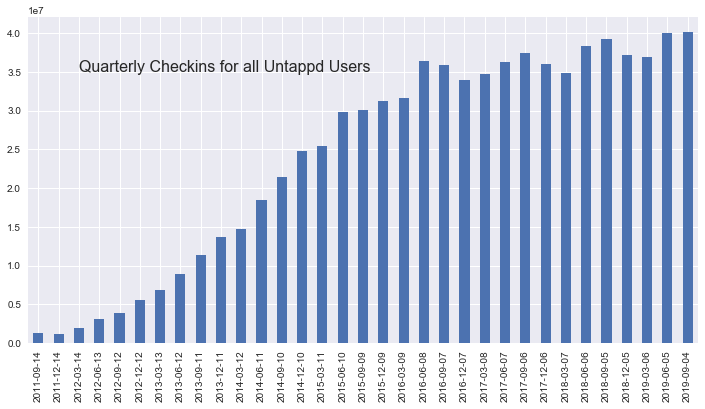

In [252]:
# This sets all times to midnight, for comparisons
dated = dated.set_index(dated.index.normalize())

# Use those quarterly dates to make a column of date bins to be able to group by them
dated['datebin'] = pd.cut(dated.index, dates)

# this makes a Series whose index is the date bins
means = dated.groupby('datebin')['checkin_id'].mean()

# Now make a column of quarterly diffs, and use the bin (index) midpoints as xticks
diffs = pd.Series([int(means[i]-means[i-1]) for i in range(1,len(means))], 
                  index=[i.mid.date() for i in means.index[1:]])
diffs.plot(kind='bar', figsize=(12,6))
plt.text(x=2, y=3.5e7, s='Quarterly Checkins for all Untappd Users', fontsize=16)
plt.show()

#### As expected, checkin growth was fastest in 2013-2015, and while the app has seen consecutive quarters of falling usage numbers 3 times since then, the overall trend is still upwards.  From June of 2015 to June of 2019 (4 years) the quarterly checkins went up by a million.  By comparison, in the 1 year from June of 2014 to June of 2015, the quarterly checkins went up more than that.  

What about for IPA's?  They seem to have followed a similar trajectory of popularity.  Let's see what percentage of checkins they've accounted for over this timeframe.

In [253]:
all_checkins = dated.groupby('datebin').size()
ipa_checkins = dated[dated.ipa].groupby('datebin').size()

ipa_pct = pd.concat([all_checkins, ipa_checkins], axis=1)

ipa_pct.head()

,0,1
datebin,,
"(2011-05-01, 2011-07-31]",20,3
"(2011-07-31, 2011-10-30]",15,7
"(2011-10-30, 2012-01-29]",216,69
"(2012-01-29, 2012-04-29]",285,113
"(2012-04-29, 2012-07-29]",126,38


In [254]:
# I'd rather see just one date on the x-axis, even if it blurs the fine-grained scale of the data
ipa_pct.index = [i.mid.date() for i in ipa_pct.index]

ipa_pct['pct'] = ipa_pct[1] * 100 / ipa_pct[0]

ipa_pct.head()

,0,1,pct
2011-06-15,20,3,15.000000
2011-09-14,15,7,46.666667
2011-12-14,216,69,31.944444
2012-03-14,285,113,39.649123
2012-06-13,126,38,30.158730


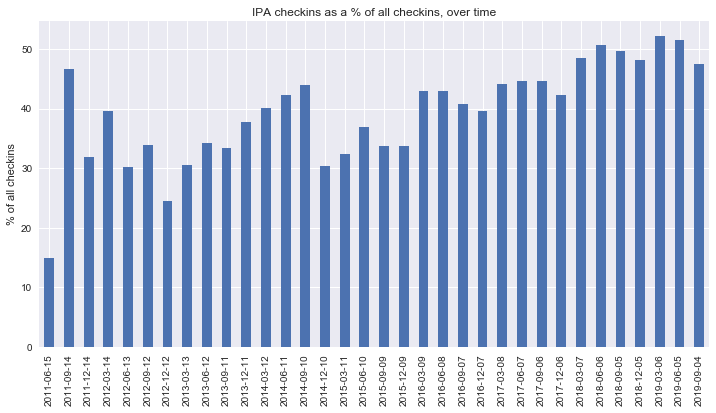

In [256]:
# Those first few quarters consist of too small a number of checkins to
## rightfully include in the following graph, but in the interest of
### keeping the dimensions similar to the previous chart, they're included.
ipa_pct.pct.plot(kind='bar', figsize=(12,6));
plt.ylabel('% of all checkins');
plt.title('IPA checkins as a % of all checkins, over time');

#### While that chart does seem to show how the popularity of IPA's is progressing over time, it should be noted that this group of 8K users was selected by who had checked in the most on a random sample of IPA's, where the IPA's were likely skewed toward recent releases.  Nevertheless, an occasional reader of beer industry headlines knows that IPA sales growth is outpacing other styles in recent years, and this chart is probably an accurate reflection of that.

Before we get into the ratings, let's take a quick look at a few more dataframe columns, starting with the distribution of abv (alcohol by volume) in these beers.

In [265]:
print(f'Number of beers with no given abv: {len(df[df.abv==0])}')
print(f'Max abv listed:  {max(df.abv)}')

Number of beers with no given abv: 15790
Max abv listed:  80.0


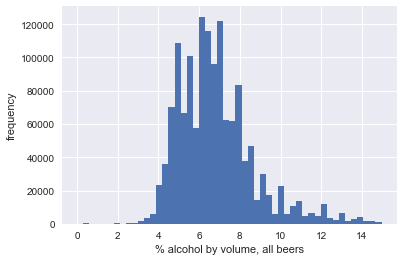

In [266]:
# Remove those outliers (abv = 80% ??) to make the histogram more accurate
_ = plt.hist(df.abv[(df.abv > 0) & (df.abv < 15)], bins=50)
_ = plt.xlabel('% alcohol by volume, all beers')
_ = plt.ylabel('frequency')
plt.show()

Compare the alcohol levels of IPA's vs other beers.

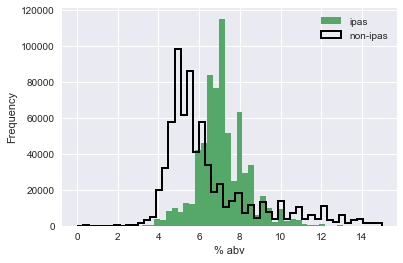

In [267]:
ipas[(ipas.abv > 0) & (ipas.abv < 15)].abv.plot(kind='hist', color='C1',
                                                label='ipas', bins=50)
non_ipas[(non_ipas.abv > 0) & (non_ipas.abv < 15)].abv.plot(kind='hist', color='k', lw=2,
                                                            histtype='step', label='non-ipas', bins=50)
plt.xlabel('% abv')
plt.legend()
plt.show()

In [269]:
print(f'The mean abv for an IPA in this dataset is {round(np.mean(ipas.abv), 3)} %')
print(f'For other beers in this dataset, the mean abv is {round(np.mean(non_ipas.abv), 3)} %')
print()
print(f'The abv standard deviation for an IPA in this dataset is {round(np.std(ipas.abv), 3)}')
print(f'For other beers in this dataset, the abv std is {round(np.std(non_ipas.abv), 3)}')

The mean abv for an IPA in this dataset is 7.112 %
For other beers in this dataset, the mean abv is 6.447 %

The abv standard deviation for an IPA in this dataset is 1.417
For other beers in this dataset, the abv std is 2.639


#### The mean abv for IPA's is higher, but the non-IPA's are spread out more and cover the extremes in both directions.  Their spread is  a consequence of their encompassing more styles.

Finally, what sorts of breweries make these checked in beers?

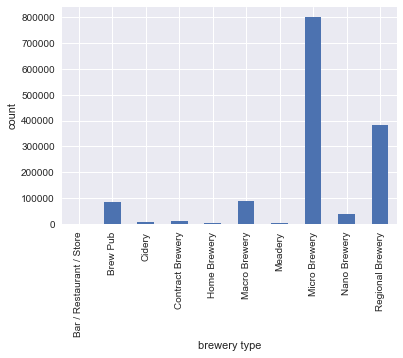

In [271]:
df.groupby('brewery_type').size().plot(kind='bar')
plt.ylabel('count')
plt.xlabel('brewery type')
plt.show()

#### Over half of the 1.4 mil checkins are for microbrews, so it's clear that the people using Untappd's app are not interested in rating and sharing with the world their consumption of macrobrews, which in reality make up the vast majority of beer sales in the U.S. and the rest of the world.


======================================================================================================================


## In this second part of the notebook we'll take a look at how ratings are distributed and how they relate to other features.

First off, there are 2 ratings columns in this dataset, one for the user who checked in ('rating_user') and another for the mean of all user ratings ever ('rating_global') for the beer.

For the most part, users can rate a beer in any 0.25 increment up to 5.00, although there are some ratings in increments of 0.10, which come from users that have paid Untappd for some sort of Premium level of the app (which is free otherwise).  I removed all the 0.00 ratings from the data, on the assumption that they are much more likely to reflect "No Rating" than "The Worst Beer Ever," and though the app defaults to 0.00 on its rating slider, it states to the user that the rating is "No Rating."  A quick look at the ratings distribution, with its scarcity of 0.25-1.75 ratings, supports this approach:  

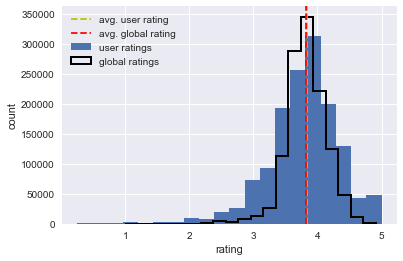

In [285]:
plt.hist(df.rating_user, bins=20, label='user ratings')
plt.hist(df[df.rating_global > 0].rating_global, histtype='step',
         color='k', bins=20, label='global ratings', lw=2)
plt.xlabel('rating')
plt.ylabel('count')
plt.axvline(x=df.rating_user.mean(), color='y', linestyle='--',
            label='avg. user rating')
plt.axvline(x=df[df.rating_global > 0].rating_global.mean(), linestyle='--',
            label='avg. global rating', color='r')
plt.legend();

#### Globally, almost all ratings averages have settled into the 3.25 - 4.5 range over time, while the local user ratings are more spread out, having so many fewer ratings per beer.

Break down the blue part of the above graph into user ratings for IPA vs non_IPA

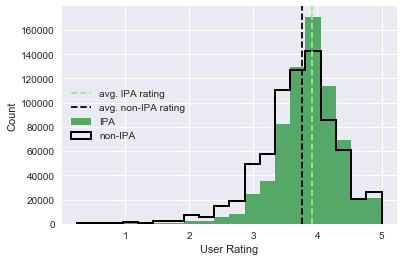

In [290]:
plt.hist(ipas.rating_user, bins=20, color='C1', label='IPA')
plt.hist(non_ipas.rating_user, bins=20, histtype='step', lw=2, label='non-IPA', color='k')
plt.xlabel('User Rating')
plt.ylabel('Count')
plt.axvline(x=ipas.rating_user.mean(), color='lightgreen', linestyle='--',
            label='avg. IPA rating')
plt.axvline(x=non_ipas.rating_user.mean(), color='k', linestyle='--',
            label='avg. non-IPA rating')
plt.legend(loc='center left');

#### The IPA's are packed pretty closely around 4-star ratings, while the non-IPA's spread out more below 4 stars and also represent more of the 5-star ratings.

A few bar charts to compare the same user/global and IPA/non-IPA splits and their means:

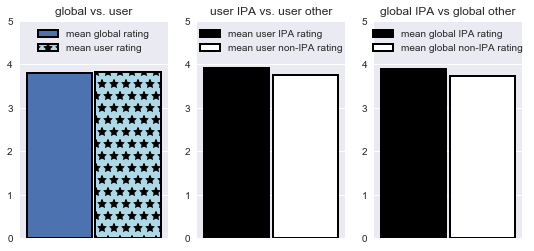

In [291]:
plt.figure(figsize=(9,4))

plt.subplot(131)
plt.bar(1, df.rating_global.mean(), width=1.9, label='mean global rating', linewidth=2, edgecolor='k')
plt.bar(3, df.rating_user.mean(), width=1.9, label='mean user rating', 
        color='lightblue', linewidth=2, edgecolor='k', hatch='*')
plt.legend(loc='upper center')
plt.ylim([0,5])
plt.xticks([])
plt.title('global vs. user');

plt.subplot(132)
plt.bar(1, ipas.rating_user.mean(), width=1.9, label='mean user IPA rating', 
        color='k', linewidth=2, edgecolor='k')
plt.bar(3, non_ipas.rating_user.mean(), width=1.9, label='mean user non-IPA rating',
       color='w', linewidth=2, edgecolor='k')
plt.legend(loc='upper center')
plt.ylim([0,5])
plt.xticks([])
plt.title('user IPA vs. user other');

plt.subplot(133)
plt.bar(1, ipas.rating_global.mean(), width=1.9, label='mean global IPA rating', 
        color='k', linewidth=2, edgecolor='k')
plt.bar(3, non_ipas.rating_global.mean(), width=1.9, label='mean global non-IPA rating',
       color='w', linewidth=2, edgecolor='k')
plt.legend(loc='upper center')
plt.ylim([0,5])
plt.xticks([])
plt.title('global IPA vs global other');

#### This group of users is slightly more generous than the rest of the world in terms of its mean rating for these beers.
#### It is more noticeably generous towards IPA's than other beers in its ratings, as is the rest of the world.